Олег Голещихин  
**Прикладная статистика**  
**ДОМАШНЕЕ ЗАДАНИЕ 5**

**Упражнение 2.** В файле shampoo.csv содержатся данные о ежемесячных продажах шампуня за трехлетний период. Подберите модель в классе SARIMA для этого временного ряда.Сделайте предсказание на три месяца вперед.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import statsmodels.api as sm
from scipy.special import inv_boxcox
from itertools import product
import warnings

In [130]:
from statsmodels.stats.descriptivestats import sign_test

In [74]:
shampoo = pd.read_csv('shampoo.csv', index_col=['Month'])
shampoo.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


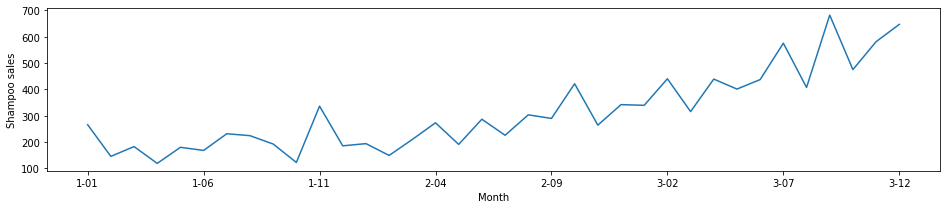

In [105]:
# посмотрим на наш временной ряд
plt.figure(figsize=(16,3))
shampoo['Sales'].plot()
plt.ylabel('Shampoo sales')
plt.show()

Судя по графику, пропусков в данных нет, начало и конец графика не отличаются явным образом друг от друга (не нужно удалять начало временного ряда). Есть явно выраженный восходящий тренд, очевидной сезонности, вроде бы, нет. Кажется, что дисперсия ряда со временем заметно не меняется.

<Figure size 1152x576 with 0 Axes>

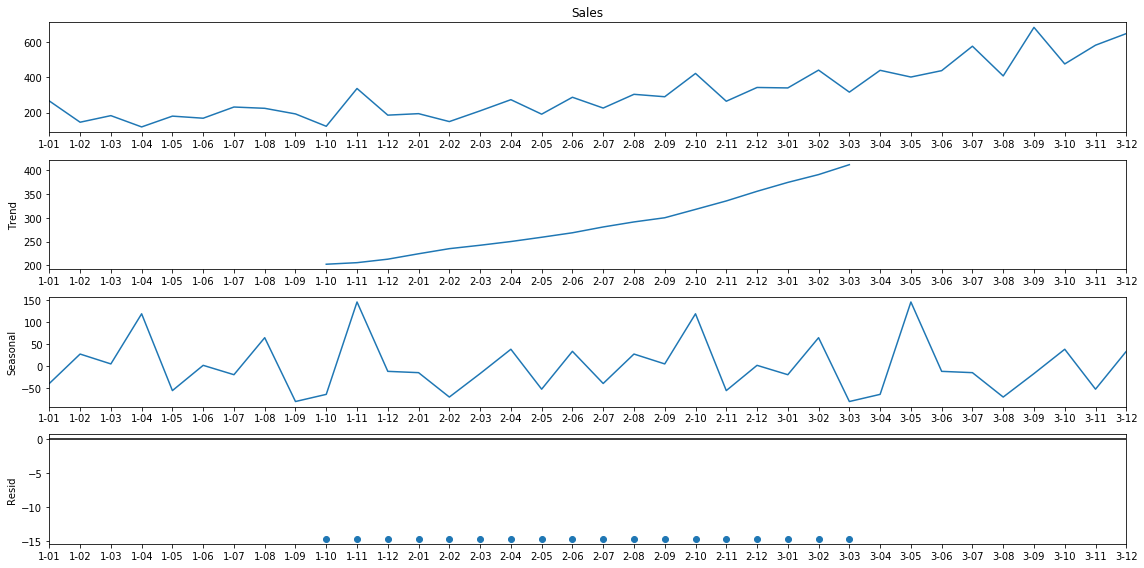

In [76]:
# выполним STL-декомпозицию ряда
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(shampoo['Sales'], period=18).plot()
plt.show()

STL-декомпозиция подтвердила выводы о наличии сильного восходящего тренда. Также видно, что есть значимая сезонность.

In [77]:
# сначала займемся стабилизацией дисперсии; хотя визуально кажется, что она не меняется со временем, 
# лишним это все равно не будет
shampoo['Sales_boxcox'], lmbd = stats.boxcox(shampoo['Sales'])
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  -0.09471316436850583


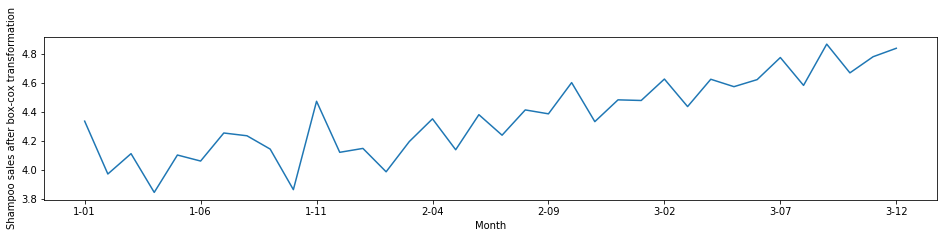

In [106]:
# посмотрим на получившийся временной ряд
plt.figure(figsize=(16,3))
shampoo['Sales_boxcox'].plot()
plt.ylabel('Shampoo sales after box-cox transformation')
plt.show()

<Figure size 1152x576 with 0 Axes>

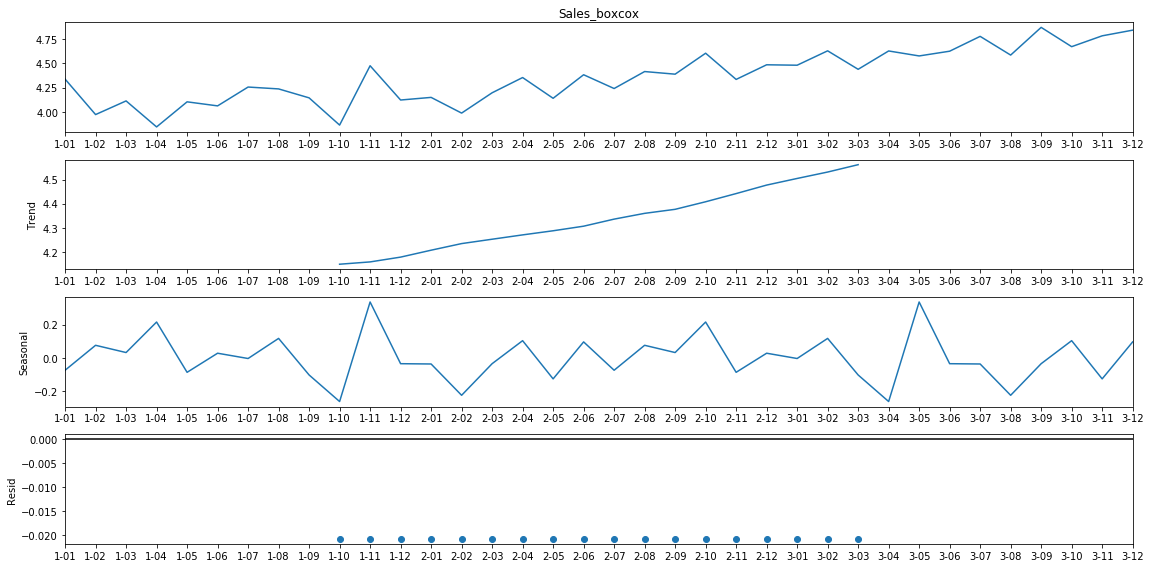

In [79]:
# также посмотрим на STL-декомпозицию преобразованного ряда
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(shampoo['Sales_boxcox'], period=18).plot()
plt.show()

Судя по STL-декомпозиции, преобразование Бокса-Кокса позволило нам избавиться от сезонности. Поэтому не будем использовать сезонное дифференцирование, сразу перейдем к обычному.

In [80]:
# попробуем избавиться от тренда с помощью дифференцирования
shampoo['Sales_boxcox_od1'] = shampoo['Sales_boxcox'] - shampoo['Sales_boxcox'].shift(1)

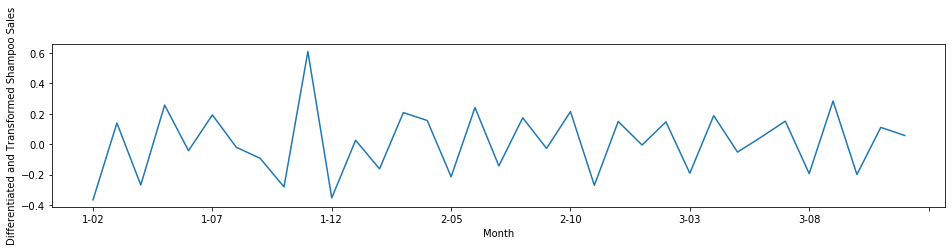

In [107]:
plt.figure(figsize(16,3))
shampoo['Sales_boxcox_od1'][1:].plot()
plt.ylabel('Differentiated and Transformed Shampoo Sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

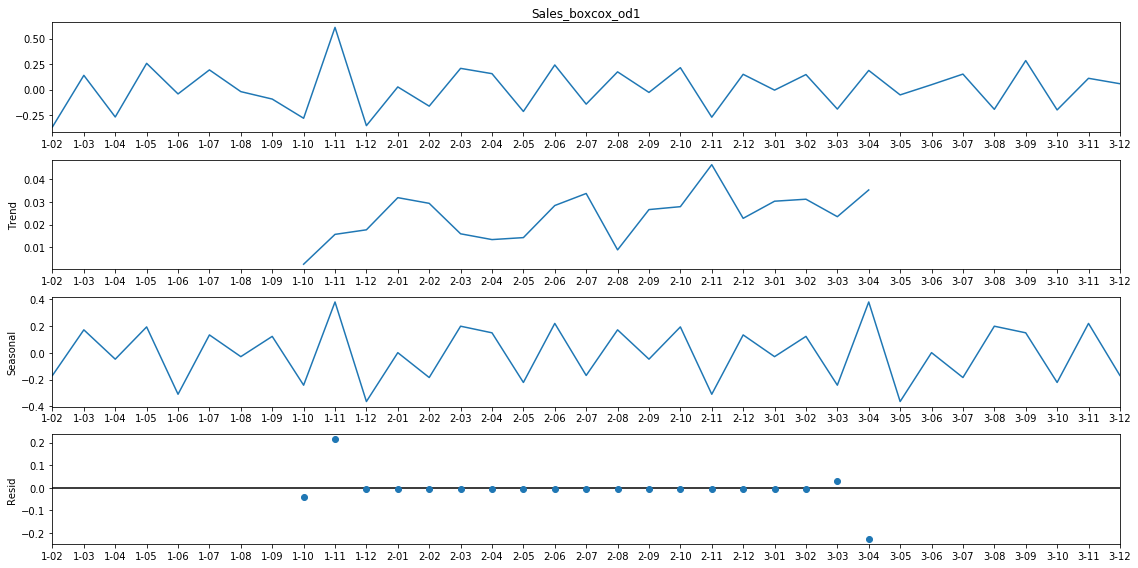

In [103]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(shampoo['Sales_boxcox_od1'][1:], period=17).plot()
plt.show()

Нам удалось избавиться от тренда, но теперь получилась, что сезонность сильно влияет на преобразованный временной ряд (значения временного ряда колеблятся от -0.25 до 0.5, а сезонности - от -0.4 до 0.4). Но попытки избавиться от сезонности "за кадром" не привели к желаемому результату, поэтому оставим все как есть.

In [109]:
# проверим при помощи критерия Дики-Фуллера гипотезу о нестационарности получившегося временного ряда
print("Критерий Дики-Фуллера для итогового ряда: pvalue =",sm.tsa.stattools.adfuller(shampoo['Sales_boxcox_od1'][1:])[1])

Критерий Дики-Фуллера для итогового ряда: pvalue = 0.001568303457000304


Критерий Дики-Фуллера отвергает гипотезу о том, что наш итоговый ряд является нестационарным.

In [111]:
# заодно еще и посмотрим на критерий Дики-Фуллера для двух других наших временных рядов
print("Критерий Дики-Фуллера для начального ряда: pvalue =",sm.tsa.stattools.adfuller(shampoo['Sales'])[1])
print("Критерий Дики-Фуллера для ряда после преобразования Бокса-Кокса: pvalue =",sm.tsa.stattools.adfuller(shampoo['Sales_boxcox'])[1])

Критерий Дики-Фуллера для начального ряда: pvalue = 1.0
Критерий Дики-Фуллера для ряда после преобразования Бокса-Кокса: pvalue = 0.9978319700298561


Видим, что до дифференцирования критерий Дики-Фуллера "уверенно" не отвергает гипотезы о нестационарности рассмотренных рядов.

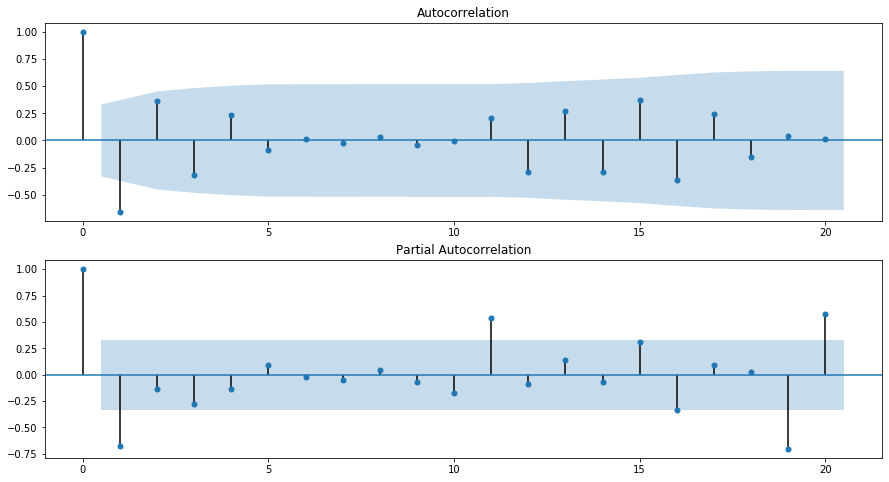

In [120]:
##### построим графики автокорреляционной и частной автокорреляционной функций
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 
sm.graphics.tsa.plot_acf(shampoo['Sales_boxcox_od1'][1:].values.squeeze(), lags=20, ax=ax1)
sm.graphics.tsa.plot_pacf(shampoo['Sales_boxcox_od1'][1:].values.squeeze(), lags=20, ax=ax2)
plt.show()

По графику автокорреляции получаем оценки для q=1, Q=0. По графику частной автокорреляции получаем оценки для p=1, P=0.

In [127]:
# создадим список из значений параметров для перебора моделей
d = 1 # количество обычных дифференцирований
D = 0 # количество сезонных дифференцирований
# ниже параметры идут в следующем порядке: p, q, P, Q
parameters_list = [[0, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0]]

In [131]:
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(shampoo['Sales_boxcox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 0)).fit(disp=-1)
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

In [132]:
# преобразуем результаты в DataFrame и добавим названия столбцов
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [133]:
# отсортируем модели по AIC
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
2,"[1, 0, 0, 0]",-25.354846
3,"[1, 1, 0, 0]",-25.151360
1,"[0, 1, 0, 0]",-22.585055
0,"[0, 0, 0, 0]",-6.768052


Лучшей моделью получилась SARIMA (1,1,0)x(0,0,0). Следующая по AIC модель имеет больше параметров, и сам AIC у нее при этом тоже больше.

In [214]:
best_model=sm.tsa.statespace.SARIMAX(shampoo['Sales_boxcox'], order=(1,1,0), seasonal_order=(0,0,0,0)).fit(disp=-1)

In [215]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:           Sales_boxcox   No. Observations:                   36
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  14.677
Date:                Mon, 05 Apr 2021   AIC                            -25.355
Time:                        00:42:56   BIC                            -22.244
Sample:                             0   HQIC                           -24.281
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6834      0.134     -5.084      0.000      -0.947      -0.420
sigma2         0.0249      0.006      4.083      0.000       0.013       0.037
Ljung-Box (Q):                       24.10   Jarque-

Обращаем внимание на то, что критерий Льюнга-Бокса не отвергает гипотезу об отсутствии автокорреляции у остатков, критерий Харке-Бера также не отвергает гипотезу о нормальном распределении остатков.  

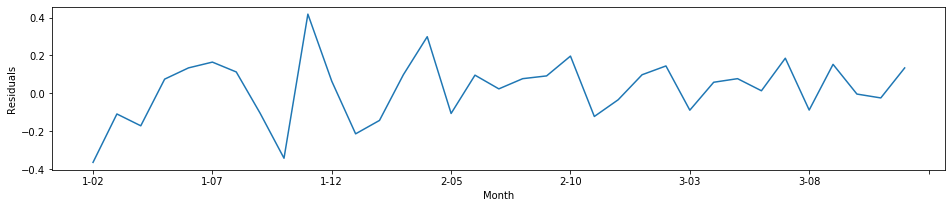

In [216]:
# посмотрим на остатки модели
plt.figure(figsize(16,3))
best_model.resid[1:].plot()
plt.ylabel('Residuals')
plt.show()

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

In [217]:
# проверим несмещенность остатков с помощью критерия знаков
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[1:])[1])

Критерий знаков для остатков: pvalue = 0.31050465907901503


In [218]:
# проверим стационарность остатков с помощью критерия Дики-Фуллера
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 0.1094764444528104


<Figure size 1152x216 with 0 Axes>

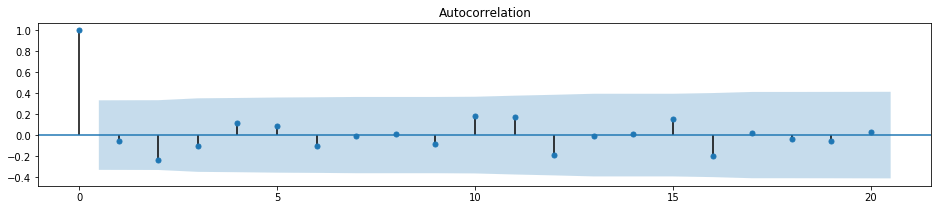

In [219]:
# проверим остатки на автокорреляцию с помощью графика
plt.figure(figsize(16,3))
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=20)
plt.show()

Критерий знаков не отверг гипотезу о несмещенности остатков. График автокорреляции показывает, что остатки независимы. А вот критерий Дики-Фуллера не стал отвергать гипотезу о нестационарности остатков даже для уровня ошибки 10% (но тут можно сделать поправку на то, что у нас довольно короткий ряд). Также вспомним, что в summary критерии Льюнга-Бокса и Харке-Бера не стали отвергать гипотезу о нормально распределении остатков. В общем, будем считать, что остатки у нашей модели получились достаточно хорошие.

In [220]:
# посмотрим, насколько хорошо наша модель приближает исходный временной ряд
shampoo['Model'] = inv_boxcox(best_model.fittedvalues, lmbd)

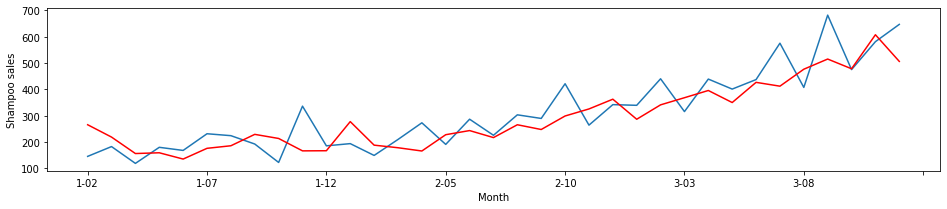

In [233]:
plt.figure(figsize(16,3))
shampoo['Sales'][1:].plot()
shampoo['Model'][1:].plot(color='r')
plt.ylabel('Shampoo sales')
pylab.show()

Картина получилась не очень красивой. Но сделаем скидку на то, что в нашей модели всего лишь два параметра p и d. И модели сложно хорошо подстроиться под фактический ряд.

In [224]:
# сделаем прогноз на 3 месяца
plot_shampoo = shampoo[['Sales','Model']]
future = pd.DataFrame(index=['4-01', '4-02', '4-03'], columns= plot_shampoo.columns)
plot_shampoo = pd.concat([plot_shampoo, future])

In [225]:
forecast = inv_boxcox(best_model.predict(start=37, end=39), lmbd)
forecast.index = ['4-01', '4-02', '4-03']

In [226]:
plot_shampoo.loc[['4-01', '4-02', '4-03'], ['Model']] = forecast

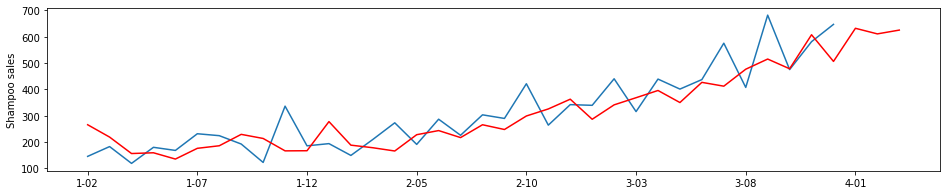

In [227]:
plt.figure(figsize(16,3))
plot_shampoo['Sales'][1:].plot()
plot_shampoo['Model'][1:].plot(color='r')
plt.ylabel('Shampoo sales')
pylab.show()

**Упражнение 3.** В файле female-births.csv содержатся данные о количестве новорожденных девочек в 1959 году в Калифорнии. Подберите модель в классе SARIMA для этого временного ряда. Сделайте предсказание на один месяц вперед.

In [238]:
birth = pd.read_csv('female-births.csv', index_col=['Date'], parse_dates=['Date'])
birth.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


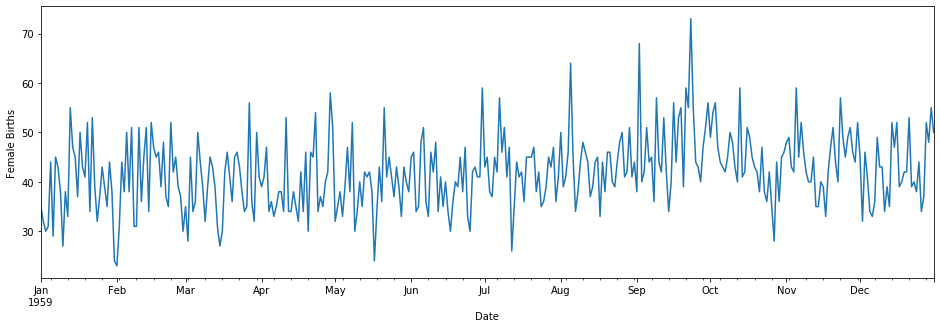

In [240]:
# визуализируем данные
plt.figure(figsize=(16,5))
birth['Births'].plot()
plt.ylabel('Female Births')
plt.show()

Визуальный анализ временного ряда не позволяет говорить о каких-то явных трендах или сезонности. Кажется, что дисперсия со временем не меняется. Начало временного ряда не отличается каким-то явным образом от его продолжения.

<Figure size 1152x576 with 0 Axes>

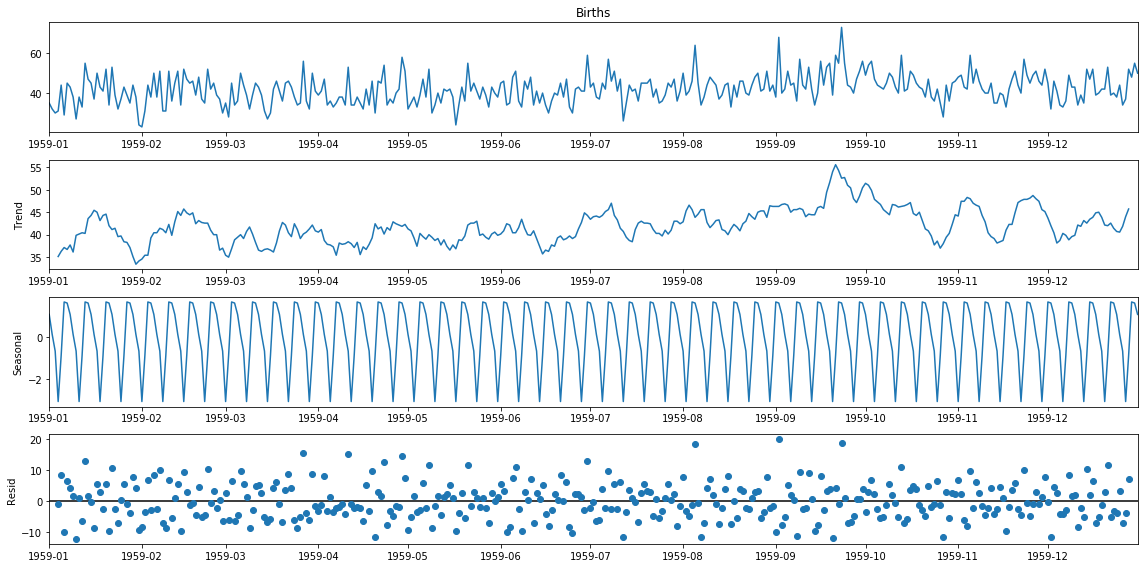

In [241]:
# выполним STL-декомпозицию ряда
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(birth['Births']).plot()
plt.show()

STL-декомпозиция показывает, что нет ни явного тренда, ни явной сезонности.

In [242]:
# сначала займемся стабилизацией дисперсии; хотя визуально кажется, что она не меняется со временем, 
# лишним это все равно не будет
birth['Births_boxcox'], lmbd = stats.boxcox(birth['Births'])

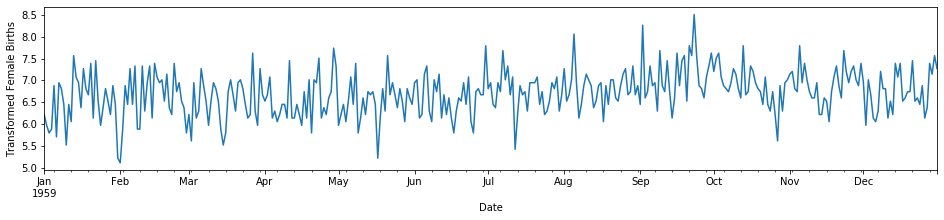

In [245]:
# посмотрим на получившийся временной ряд
plt.figure(figsize=(16,3))
birth['Births_boxcox'].plot()
plt.ylabel('Transformed Female Births')
plt.show()

<Figure size 1152x576 with 0 Axes>

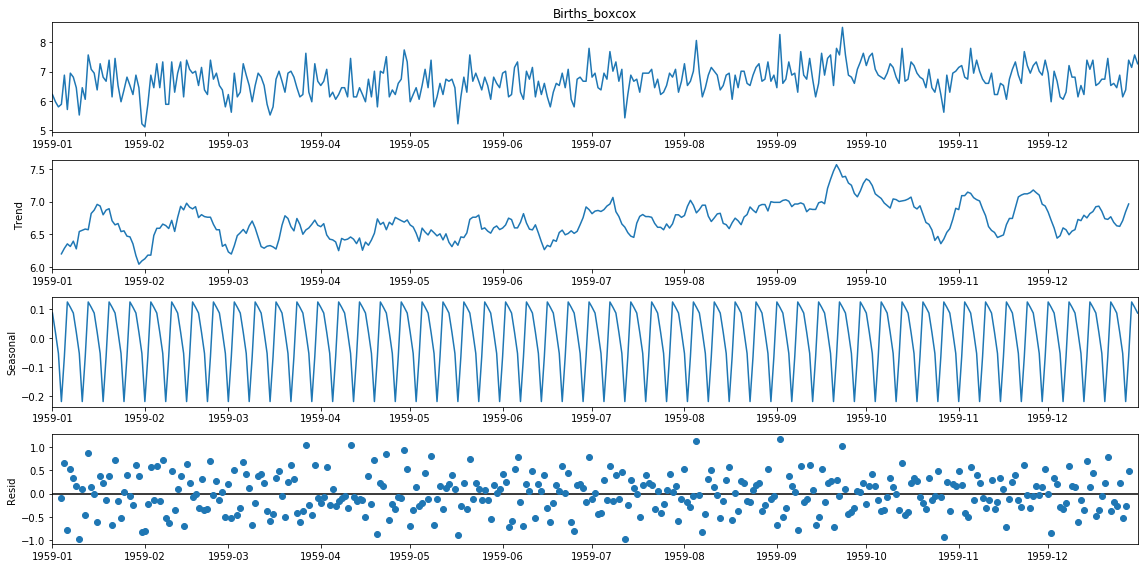

In [246]:
# также посмотрим на STL-декомпозицию преобразованного ряда
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(birth['Births_boxcox']).plot()
plt.show()